# Import Libraries

In [15]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import time

# from sklearn.feature_selection import f_regression

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from statsmodels.stats.outliers_influence import variance_inflation_factor

from lazypredict.Supervised import LazyRegressor

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor


In [2]:
pd.set_option('display.float_format', '{:.6f}'.format)

# Data Cleaning

In [143]:
# Import Data:
Ames_HousePrice = pd.read_csv('Ames_HousePrice.csv', index_col=0)
real_coords = pd.read_csv("real_estate_with_coordinates.csv")

# One row is duplicated in Ames_HousePrice df, once dropped there are no duplicate PID values
Ames_HousePrice = Ames_HousePrice.drop_duplicates()
real_coords = real_coords.drop_duplicates()

# Dataframe merging
real_estate_columns_to_keep = ['GeoRefNo','Prop_Addr', 'MA_Zip1','latitude', 'longitude']
housing_coords = pd.merge(Ames_HousePrice, real_coords[real_estate_columns_to_keep],
                               left_on='PID', right_on='GeoRefNo', how='left')

# Remove any duplicate rows created in merge
housing_coords = housing_coords.drop_duplicates()

# Remove outliers 528351010 has too high sale price, 908154205, has too much area
# housing_coords = housing_coords[~housing_coords['PID'].isin([528351010, 908154205])]

# Drop Columns with too many NA Values
# housing_coords.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence'],axis=1,inplace=True)

# Update missing gps data rows:
# housing_coords = housing_coords.dropna(subset=['latitude'])
mean_latitude = housing_coords['latitude'].mean()
housing_coords['latitude'].fillna(mean_latitude, inplace=True)

mean_longitude = housing_coords['longitude'].mean()
housing_coords['longitude'].fillna(mean_longitude, inplace=True)

# DistanceToISU column contains the distance of each property to Iowa State University
# Coordinates of Iowa State University
isu_latitude = 42.0239
isu_longitude = -93.6476
# Function to calculate Haversine distance
def haversine(lat1, lon1, lat2, lon2):
    # Radius of the Earth in miles
    radius = 3958.8
    # Convert latitude and longitude from degrees to radians
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)
    # Differences in latitude and longitude
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    # Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    # Calculate the distance
    distance = radius * c
    return distance
# Calculate distance for each property address
housing_coords['DistanceToISU'] = housing_coords.apply(
    lambda row: haversine(row['latitude'], row['longitude'], isu_latitude, isu_longitude), axis=1)

# 2 rows with gps info but missing zip:
specified_addresses = ['2010 KILDEE ST', '1310 WOODSTOCK AVE']
# Update 'Zipcode' to 50014 where 'Address' is in the specified list
housing_coords.loc[housing_coords['Prop_Addr'].isin(specified_addresses), 'MA_Zip1'] = 50014
    
# 'Prop_Addr' column useful for EDA and data cleaning but not for modeling
housing_coords.drop('Prop_Addr',axis=1,inplace=True)

# Reset index after dropping rows so flitering by iloc works smoothly
housing_coords.reset_index(drop=True,inplace=True)

# This is good for EDA but since it is calculated from the target it will cause 
# data leakage and shouldn't be included in modeling
    # # Added PricePerSF Column
    # housing_coords['PricePerSF'] = housing_coords['SalePrice'] / housing_coords['GrLivArea']

# Delete utilities column, it has 2496/2497 with same value
    # housing_coords.Utilities.value_counts() # <-- No N/As here
housing_coords.drop('Utilities',axis=1,inplace=True)

# Fix Row with Missing Values in Basement Categories
housing_coords.loc[housing_coords.PID==903230120,[
    'BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF',
    'BsmtFullBath','BsmtHalfBath']] = housing_coords.loc[housing_coords.PID==903230120,[
    'BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath']].fillna(0)

# Masonry Veneer (Type/Area)
    # If Type = 'None' but Area != 0, Type updated to mode
    # N/As updated to None for Type and 0 for Area
idx = (housing_coords['MasVnrArea'].isna()) & (housing_coords['MasVnrType'].isna())
housing_coords.loc[idx, 'MasVnrArea'] = housing_coords.loc[idx, 'MasVnrArea'].fillna(0)
housing_coords.loc[idx, 'MasVnrType'] = housing_coords.loc[idx, 'MasVnrType'].fillna('None')
mode_MasVnrType = housing_coords.loc[housing_coords.MasVnrType!='None'].MasVnrType.mode()[0]
idx2 = (housing_coords['MasVnrArea']!=0) & (housing_coords['MasVnrType']== 'None')
housing_coords.loc[idx2, 'MasVnrType'] = housing_coords.loc[idx2, 'MasVnrType'].fillna(mode_MasVnrType)

# Fix Row with Missing Values in GarageCars & GarageArea Categories
idx3 = (housing_coords['GarageArea']!=0) & (housing_coords['GarageType']=='Detchd')
mean_GarageArea = round(housing_coords.loc[idx3, 'GarageArea'].mean())
housing_coords.loc[housing_coords.PID==910201180,'GarageArea'] = mean_GarageArea
idx4 = housing_coords['GarageType']=='Detchd'
mode_GarageCars = housing_coords.loc[idx4, 'GarageCars'].mode()[0]
housing_coords.loc[housing_coords.PID==910201180,'GarageCars'] = mode_GarageCars

# Fill GarageYrBlt to match Year House Was Built
housing_coords['GarageYrBlt'] = housing_coords['GarageYrBlt'].fillna(housing_coords['YearBuilt']) # 129 N/A

# Fix Row where Year Remodeled occured before Year Built
housing_coords.loc[housing_coords.PID==907194160,'YearRemodAdd'] = \
housing_coords.loc[housing_coords.PID==907194160,'YearBuilt']

# Fill with Most Common (Categorical) Value:
mode_Electrical = housing_coords['Electrical'].mode()[0] # 1 N/A
housing_coords['Electrical'].fillna(mode_Electrical, inplace=True)

# 451 N/A values for Lot Frontage
    # The average ratio of LotFrontage/LotArea was calculated for each
    # LotType & LotShape and this percentage factor was used to calculate
    # The missing LotFrontage Values (since LotArea was not missing)
lot_df = housing_coords.loc[housing_coords['LotFrontage'].notna()][[
    'LotFrontage','LotArea','LotConfig','LotShape']]
lot_df2 = lot_df.groupby(['LotConfig','LotShape']).agg({'LotFrontage':'mean','LotArea':'mean'})
lot_df2['PCT_Frontage']=lot_df2['LotFrontage']/lot_df2['LotArea']
percentage_factor_mapping = lot_df2['PCT_Frontage'].to_dict()

# Update the NaN values in 'LotFrontage' using the mapping and LotArea
housing_coords['LotFrontage'] = housing_coords.apply(
    lambda row: round(row['LotArea'] * percentage_factor_mapping.get(
        (row['LotConfig'], row['LotShape']), 1.0)), axis=1)

# Combine Full and Half Bathroom Categories
housing_coords['BsmtBath']=housing_coords['BsmtFullBath']+0.5*housing_coords['BsmtHalfBath']
housing_coords['Bath']=housing_coords['FullBath']+0.5*housing_coords['HalfBath']
housing_coords.drop(['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'],axis=1,inplace=True)
mean_BsmtBath = round(housing_coords.BsmtBath.mean()*2)/2 # Round to nearest 0.5
housing_coords['BsmtBath'].fillna(mean_BsmtBath, inplace=True)

# Replace TotRmsAbvGrd with MiscRmsAbvGrd to avoid multicollinearity?
    # These are not bedroom, kitchen, nor bathroom
housing_coords['MiscRmsAbvGrd'] = housing_coords.TotRmsAbvGrd - housing_coords.BedroomAbvGr - housing_coords.KitchenAbvGr
housing_coords.drop('TotRmsAbvGrd',axis=1,inplace=True)

# Change YearBuilt to Age so it works better as a numerical variable
housing_coords['Age'] = housing_coords['YrSold'] - housing_coords['YearBuilt']
housing_coords.drop('YearBuilt',axis=1,inplace=True)

# Fill NaN with 'None' for categorical columns
missing_categorical_features = ['FireplaceQu', 'GarageCond','GarageQual','GarageFinish', 'MasVnrType',
                                'GarageType', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'Alley',
                                'BsmtFinType2', 'BsmtExposure', 'PoolQC', 'MiscFeature', 'Fence' ]
housing_coords[missing_categorical_features] = housing_coords[missing_categorical_features].fillna('None')

# Drop PID & GeoRefNo. They are only needed for merging
housing_coords.drop(['GeoRefNo', 'PID'],axis=1,inplace=True)

# Replace MSSubClass numerical values with letter values since it is categorical
MSSubClass_mapping_dict = {20:'A', 30:'B', 40:'C', 45:'D', 50:'E', 60:'F', 70:'G', 75:'H', 
                           80:'I', 85:'J', 90:'K', 120:'L', 150:'M', 160:'N', 180:'O', 190:'P'}
housing_coords['MSSubClass'] = housing_coords['MSSubClass'].replace(MSSubClass_mapping_dict)

# Update Zip Code Column.  There are only a few zips listed actually in Ames. The rest are
    # changed to 'other' rather than search the address and update to the appropriate one.
    # The column is also treated as a categorical variable
housing_coords['MA_Zip1'].fillna(99, inplace=True)
housing_coords['MA_Zip1'] = housing_coords['MA_Zip1'].astype(int)
housing_coords['MA_Zip1'] = housing_coords['MA_Zip1'].astype(str)
zip_update = ~housing_coords['MA_Zip1'].isin(['99','50010', '50011', '50012', '50013', '50014'])
housing_coords.loc[zip_update, 'MA_Zip1'] = 'other'

# Addition of Total Square Feet Column:
housing_coords['TotalSF'] = housing_coords.GrLivArea + housing_coords.TotalBsmtSF

print(f'Shape of DataFrame: {housing_coords.shape}')

Shape of DataFrame: (2579, 82)


# Convert Ordinal Numeric Columns to Numeric

In [144]:
numeric_df = housing_coords.select_dtypes(include='number')
corr_sorted_numerical_columns = abs(numeric_df.corr())['SalePrice'].sort_values(ascending=False).drop(['SalePrice'])
numerical_columns = list(corr_sorted_numerical_columns.index)
numerical_columns.sort()
categorical_columns = list(set(housing_coords.columns) - set(numeric_df.corr()['SalePrice'].index))
categorical_columns.sort()
ordinal_columns = ['BsmtCond', 'BsmtQual', 'ExterCond', 'ExterQual', 'FireplaceQu', 
                   'GarageCond', 'GarageQual', 'HeatingQC', 'KitchenQual', 'BsmtExposure',
                  'BsmtFinType1', 'BsmtFinType2', 'Functional', 'GarageFinish', 'LandSlope',
                  'LotShape', 'PoolQC']
non_ordinal_columns = list(set(categorical_columns)-set(ordinal_columns))
non_ordinal_columns.sort()
all_cols = list(housing_coords.columns)
all_cols.sort()

print('Initial Counts:')
print(f'{len(numerical_columns)} Numerical Columns')
print(f'{len(categorical_columns)} Total Categorical Columns')
print(f'{len(non_ordinal_columns)} Non-Ordinal Categorical Columns')



# Ordinal Column Mapping
qual_mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}
qual_ordinal_columns = ['BsmtCond', 'BsmtQual', 'ExterCond', 'ExterQual', 'FireplaceQu', 
                        'GarageCond', 'GarageQual', 'HeatingQC', 'KitchenQual']
for col in qual_ordinal_columns:
    col_numerical = f'{col}_n'
    housing_coords[col_numerical] = housing_coords[col].map(qual_mapping)

BsmtExposure_mapping = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0}
housing_coords['BsmtExposure_n'] = housing_coords['BsmtExposure'].map(BsmtExposure_mapping)

BsmtFinType_mapping = {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0}
housing_coords['BsmtFinType1_n'] = housing_coords['BsmtFinType1'].map(BsmtFinType_mapping)
housing_coords['BsmtFinType2_n'] = housing_coords['BsmtFinType2'].map(BsmtFinType_mapping)

Functional_mapping = {'Typ':7, 'Min1': 6, 'Min2': 5, 'Mod': 4, 'Maj1': 3, 'Maj2': 2, 'Sev': 1, 'Sal': 0}
housing_coords['Functional_n'] = housing_coords['Functional'].map(Functional_mapping)

GarageFinish_mapping = {'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0}
housing_coords['GarageFinish_n'] = housing_coords['GarageFinish'].map(GarageFinish_mapping)

LandSlope_mapping = {'Gtl': 2, 'Mod': 1, 'Sev': 0}
housing_coords['LandSlope_n'] = housing_coords['LandSlope'].map(LandSlope_mapping)

LotShape_mapping = {'Reg': 3, 'IR1': 2, 'IR2': 1, 'IR3': 0}
housing_coords['LotShape_n'] = housing_coords['LotShape'].map(LotShape_mapping)

PoolQC_mapping = {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'None': 0}
housing_coords['PoolQC_n'] = housing_coords['PoolQC'].map(PoolQC_mapping)

housing_coords.drop(ordinal_columns, axis=1, inplace=True)


# NEW COUNTS
numeric_df = housing_coords.select_dtypes(include='number')
corr_sorted_numerical_columns = (numeric_df.corr()['SalePrice']).sort_values(ascending=False).drop(['SalePrice'])
numerical_columns = list(corr_sorted_numerical_columns.index)
numerical_columns.sort()
categorical_columns = list(set(housing_coords.columns) - set(numeric_df.corr()['SalePrice'].index))
categorical_columns.sort()

print('\nUpdated Counts:')
print(f'{len(numerical_columns)} Numerical Columns')
print(f'{len(categorical_columns)} Categorical Columns')

Initial Counts:
37 Numerical Columns
44 Total Categorical Columns
27 Non-Ordinal Categorical Columns

Updated Counts:
54 Numerical Columns
27 Categorical Columns


In [12]:
df_with_dummies = pd.get_dummies(housing_coords, columns=categorical_columns, drop_first=False)
sorted_features_dummies = abs(df_with_dummies.corr()[['SalePrice']]).sort_values('SalePrice',ascending=False).drop(['SalePrice']).head(20).index
# sorted_features_dummies

In [13]:
df_numerical = housing_coords.copy()
for feature in categorical_columns:
    col_map = {}
    for i in range(len(df_numerical[feature].unique())):
        col_map[list(df_numerical[feature].unique())[i]] = i+1
    df_numerical[feature] = df_numerical[feature].map(col_map)

sorted_features_numerical = abs(df_numerical.corr()[['SalePrice']]).sort_values('SalePrice',ascending=False).drop(['SalePrice']).head(20).index
# sorted_features_numerical

Feature importance (correlation?) can be determined from the model after it has been fit:

gbmr.feature_importances_

# 3 learning rates, all other parameters the same
#### .01 is best for numerical and dummies

In [16]:
start_time = time.time()

X = df_with_dummies.drop('SalePrice', axis=1)
y = df_with_dummies['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
steps = range(100, 10100, 1000) # 14100 would be find cap after flattening.

gbmr = GradientBoostingRegressor(n_estimators=10100, max_depth=4, learning_rate=0.1, 
                min_samples_leaf=1, subsample=0.5, random_state=42)
gbmr.fit(X_train, y_train)
gen = gbmr.staged_predict(X_test)
r2_values_1d = []
for n, predicted_targets in enumerate(gen):
    if n not in steps:
        continue
    r2 = r2_score(y_test, predicted_targets)
    r2_values_1d.append(r2)
    
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.2f} seconds")



X = df_with_dummies.drop('SalePrice', axis=1)
y = df_with_dummies['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
steps = range(100, 10100, 1000) # 14100 would be find cap after flattening.

gbmr = GradientBoostingRegressor(n_estimators=10100, max_depth=4, learning_rate=0.05, 
                min_samples_leaf=1, subsample=0.5, random_state=42)
gbmr.fit(X_train, y_train)
gen = gbmr.staged_predict(X_test)
r2_values_05d = []
for n, predicted_targets in enumerate(gen):
    if n not in steps:
        continue
    r2 = r2_score(y_test, predicted_targets)
    r2_values_05d.append(r2)
    
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.2f} seconds")



X = df_with_dummies.drop('SalePrice', axis=1)
y = df_with_dummies['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
steps = range(100, 10100, 1000) # 14100 would be find cap after flattening.

gbmr = GradientBoostingRegressor(n_estimators=10100, max_depth=4, learning_rate=0.01, 
                min_samples_leaf=1, subsample=0.5, random_state=42)
gbmr.fit(X_train, y_train)
gen = gbmr.staged_predict(X_test)
r2_values_01d = []
for n, predicted_targets in enumerate(gen):
    if n not in steps:
        continue
    r2 = r2_score(y_test, predicted_targets)
    r2_values_01d.append(r2)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.2f} seconds")

Elapsed Time: 72.19 seconds
Elapsed Time: 144.20 seconds
Elapsed Time: 216.02 seconds


In [18]:
start_time = time.time()

X = df_numerical.drop('SalePrice', axis=1)
y = df_numerical['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
steps = range(100, 10100, 1000) # 14100 would be find cap after flattening.

gbmr = GradientBoostingRegressor(n_estimators=10100, max_depth=4, learning_rate=0.1, 
                min_samples_leaf=1, subsample=0.5, random_state=42)
gbmr.fit(X_train, y_train)
gen = gbmr.staged_predict(X_test)
r2_values_1n = []
for n, predicted_targets in enumerate(gen):
    if n not in steps:
        continue
    r2 = r2_score(y_test, predicted_targets)
    r2_values_1n.append(r2)
    
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.2f} seconds")

gbmr = GradientBoostingRegressor(n_estimators=10100, max_depth=4, learning_rate=0.05, 
                min_samples_leaf=1, subsample=0.5, random_state=42)
gbmr.fit(X_train, y_train)
gen = gbmr.staged_predict(X_test)
r2_values_05n = []
for n, predicted_targets in enumerate(gen):
    if n not in steps:
        continue
    r2 = r2_score(y_test, predicted_targets)
    r2_values_05n.append(r2)
    
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.2f} seconds")

gbmr = GradientBoostingRegressor(n_estimators=10100, max_depth=4, learning_rate=0.01, 
                min_samples_leaf=1, subsample=0.5, random_state=42)
gbmr.fit(X_train, y_train)
gen = gbmr.staged_predict(X_test)
r2_values_01n = []
for n, predicted_targets in enumerate(gen):
    if n not in steps:
        continue
    r2 = r2_score(y_test, predicted_targets)
    r2_values_01n.append(r2)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.2f} seconds")

Elapsed Time: 61.45 seconds
Elapsed Time: 123.40 seconds
Elapsed Time: 185.14 seconds


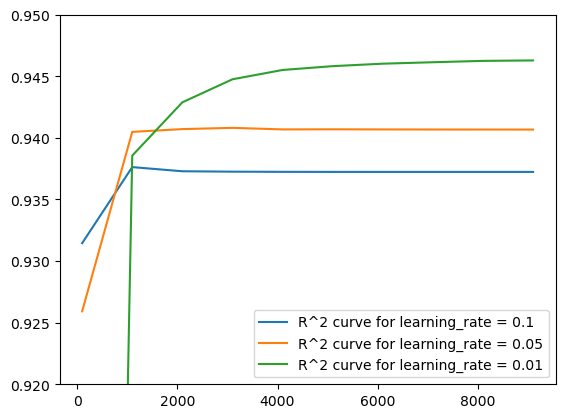

In [32]:
plt.plot(steps, r2_values_1d, label=r'R^2 curve for learning_rate = 0.1')
plt.plot(steps, r2_values_05d, label=r'R^2 curve for learning_rate = 0.05')
plt.plot(steps, r2_values_01d, label=r'R^2 curve for learning_rate = 0.01')
plt.ylim(0.92,0.95)
# plt.xlim(1000,3500)
plt.legend(loc=4)

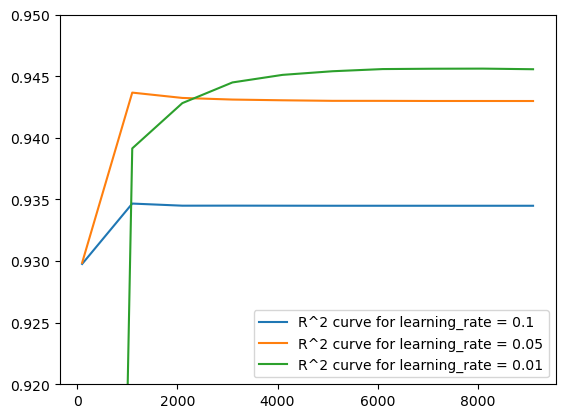

In [33]:
plt.plot(steps, r2_values_1n, label=r'R^2 curve for learning_rate = 0.1')
plt.plot(steps, r2_values_05n, label=r'R^2 curve for learning_rate = 0.05')
plt.plot(steps, r2_values_01n, label=r'R^2 curve for learning_rate = 0.01')
plt.ylim(0.92,0.95)
# plt.xlim(1000,3500)
plt.legend(loc=4)

Elapsed Time: 75.22 seconds


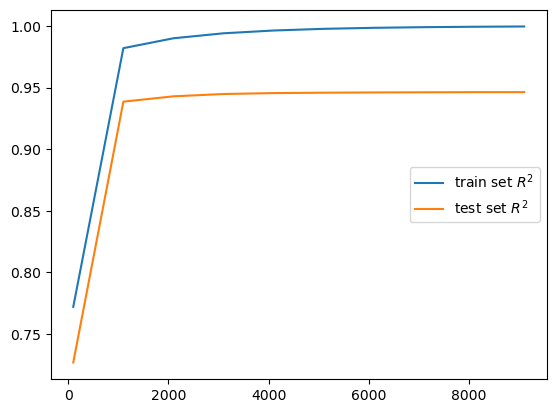

In [39]:
gbmr = GradientBoostingRegressor()

start_time = time.time()

# Separate features and target variable
X = df_with_dummies.drop('SalePrice', axis=1)
y = df_with_dummies['SalePrice']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
n_estimators = 10100
gbmr.set_params(n_estimators=n_estimators, max_depth=4, learning_rate=0.01, 
                min_samples_leaf=1, subsample=0.5, random_state=42)
train_r2d = []
test_r2d  = []
steps = range(100,10100,1000)

gbmr.fit(X_train, y_train)
gen_train = gbmr.staged_predict(X_train)
gen_test  = gbmr.staged_predict(X_test)

for n in range(n_estimators):
           predicted_train = next(gen_train)
           predicted_test  = next(gen_test)
           if n not in steps: continue
           train_r2d.append(r2_score(y_train, predicted_train))
           test_r2d.append(r2_score(y_test, predicted_test))   

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.2f} seconds")
plt.plot(steps, train_r2d, label='train set $R^2$')
plt.plot(steps, test_r2d, label='test set $R^2$')
plt.legend(loc=7)

Elapsed Time: 62.40 seconds


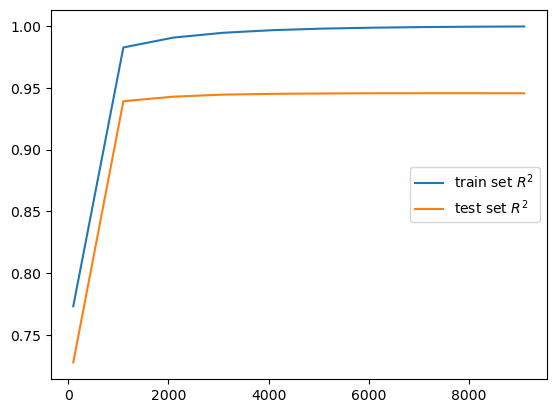

In [40]:
gbmr = GradientBoostingRegressor()

start_time = time.time()

# Separate features and target variable
X = df_numerical.drop('SalePrice', axis=1)
y = df_numerical['SalePrice']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
n_estimators = 10100
gbmr.set_params(n_estimators=n_estimators, max_depth=4, learning_rate=0.01, 
                min_samples_leaf=1, subsample=0.5, random_state=42)
train_r2n = []
test_r2n  = []
steps = range(100,10100,1000)

gbmr.fit(X_train, y_train)
gen_train = gbmr.staged_predict(X_train)
gen_test  = gbmr.staged_predict(X_test)

for n in range(n_estimators):
           predicted_train = next(gen_train)
           predicted_test  = next(gen_test)
           if n not in steps: continue
           train_r2n.append(r2_score(y_train, predicted_train))
           test_r2n.append(r2_score(y_test, predicted_test))   

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.2f} seconds")
plt.plot(steps, train_r2n, label='train set $R^2$')
plt.plot(steps, test_r2n, label='test set $R^2$')
plt.legend(loc=7)

In [42]:
print(f'dummies max r2:{max(test_r2d)}')
print(f'numerical max r2:{max(test_r2n)}')


dummies max r2:0.946286440682645
numerical max r2:0.9456215786778563


In [47]:
start_time = time.time()

# Assuming your target variable is in the 'SalePrice' column
target_column = 'SalePrice'

# Separate features and target variable
X = df_numerical.drop(target_column, axis=1)
y = df_numerical[target_column]

gbmr = GradientBoostingRegressor()

gbmr.set_params(n_estimators=6000, max_depth=4, learning_rate=0.01, 
                min_samples_leaf=1, subsample=0.5, random_state=42)

r2_scorelist = []

kf = KFold(n_splits=5, shuffle=True, random_state=99)

# Loop over each fold
for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the model on the training data
    gbmr.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = gbmr.predict(X_test)
    
    # Calculate R-squared for this fold
    r2 = r2_score(y_test, y_pred)
    r2_scorelist.append(r2)
    # MSE =  mean_squared_error(y_test, y_pred)
    # MAE =  mean_absolute_error(y_test, y_pred)

    # Append results to the list
    # results_list.append({'Model': model_name, 'R2': r2, 'MSE': MSE, 'MAE': MAE})
    # results_list.append({'Fold': train_index, 'R2': r2})

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Fold {train_index} Completed. Elapsed Time: {elapsed_time:.2f} seconds")

mean_r2 = sum(r2_scorelist) / len(r2_scorelist)
# print(gbmr.get_params)
print(f"Average R^2 for model: {mean_r2}")

Elapsed Time: 36.42 seconds
Elapsed Time: 72.79 seconds
Elapsed Time: 109.25 seconds
Elapsed Time: 145.72 seconds
Elapsed Time: 182.09 seconds


[0.9550957568590143,
 0.9384959691795408,
 0.934054063711985,
 0.9403146464696401,
 0.9421727625668617]

<bound method BaseEstimator.get_params of GradientBoostingRegressor(learning_rate=0.01, max_depth=4, n_estimators=6000,
                          random_state=42, subsample=0.5)>

# Code to run so you are alerted something else has finished

In [1]:
# from IPython.display import Audio
# import numpy as np

# Define a simple sound wave
rate = 44100  # sample rate
duration = 4.0  # seconds
frequency = 220.0  # Hz

t = np.linspace(0, duration, int(rate * duration))
audio_data = np.sin(2 * np.pi * frequency * t)

# Play the sound
Audio(audio_data, rate=rate, autoplay=True)


NameError: name 'np' is not defined

param_grid
-    'learning_rate': [0.1, 0.05, 0.01, 0.001],
-    'subsample': [1.0, 0.8, 0.7, 0.6, 0.5],
-    'n_estimators': [100, 200, 300],  # Add more values based on your computational resources
-    'max_depth': [3, 4, 5],  # Adjust based on your dataset characteristics
-    'min_samples_split': [2, 5, 10],
-    'min_samples_leaf': [1, 2, 4]

In [93]:
start_time = time.time()

# Assuming your target variable is in the 'SalePrice' column
target_column = 'SalePrice'

# Separate features and target variable
X = df_numerical.drop(target_column, axis=1)
y = df_numerical[target_column]

gbmr = GradientBoostingRegressor()

gbmr.set_params(n_estimators=6000, max_depth=4, learning_rate=0.01, 
                min_samples_leaf=1, subsample=0.5, random_state=42)

results_list = []

for i in [0.01, 0.03, 0.05, 0.06]:
    gbmr.set_params(learning_rate=i)
    r2_scorelist = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    # Loop over each fold
    for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Fit the model on the training data
        gbmr.fit(X_train, y_train)
        
        # Make predictions on the test data
        y_pred = gbmr.predict(X_test)
        
        # Calculate R-squared for this fold
        r2 = r2_score(y_test, y_pred)
        r2_scorelist.append(r2)
    
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Learning Rate {i} Fold {fold} Completed. Elapsed Time: {elapsed_time:.2f} seconds")
    
    mean_r2 = sum(r2_scorelist) / len(r2_scorelist)

    results_list.append({'MeanR2': mean_r2, 'Learning_Rate': i})

results_df_temp = pd.DataFrame(results_list)
results_df_temp

Learning Rate 0.01 Fold 1 Completed. Elapsed Time: 37.06 seconds
Learning Rate 0.01 Fold 2 Completed. Elapsed Time: 73.88 seconds
Learning Rate 0.01 Fold 3 Completed. Elapsed Time: 110.67 seconds
Learning Rate 0.01 Fold 4 Completed. Elapsed Time: 147.43 seconds
Learning Rate 0.01 Fold 5 Completed. Elapsed Time: 184.20 seconds
Learning Rate 0.03 Fold 1 Completed. Elapsed Time: 220.93 seconds
Learning Rate 0.03 Fold 2 Completed. Elapsed Time: 257.93 seconds
Learning Rate 0.03 Fold 3 Completed. Elapsed Time: 294.83 seconds
Learning Rate 0.03 Fold 4 Completed. Elapsed Time: 331.64 seconds
Learning Rate 0.03 Fold 5 Completed. Elapsed Time: 369.06 seconds
Learning Rate 0.05 Fold 1 Completed. Elapsed Time: 406.16 seconds
Learning Rate 0.05 Fold 2 Completed. Elapsed Time: 443.31 seconds
Learning Rate 0.05 Fold 3 Completed. Elapsed Time: 480.62 seconds
Learning Rate 0.05 Fold 4 Completed. Elapsed Time: 518.03 seconds
Learning Rate 0.05 Fold 5 Completed. Elapsed Time: 555.55 seconds
Learning Rat

,MeanR2,Learning_Rate
0,0.942093,0.010000
1,0.940227,0.030000
2,0.938881,0.050000
3,0.939262,0.060000


In [98]:
start_time = time.time()

# Assuming your target variable is in the 'SalePrice' column
target_column = 'SalePrice'

# Separate features and target variable
X = df_numerical.drop(target_column, axis=1)
y = df_numerical[target_column]

gbmr = GradientBoostingRegressor()

gbmr.set_params(n_estimators=6000, max_depth=4, learning_rate=0.01, 
                min_samples_leaf=1, subsample=0.5, random_state=42)

results_list = []

for i in [0.005, 0.01, 0.015, 0.02]:
    gbmr.set_params(learning_rate=i)
    r2_scorelist = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    # Loop over each fold
    start_time1 = time.time()
    for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Fit the model on the training data
        gbmr.fit(X_train, y_train)
        
        # Make predictions on the test data
        y_pred = gbmr.predict(X_test)
        
        # Calculate R-squared for this fold
        r2 = r2_score(y_test, y_pred)
        r2_scorelist.append(r2)
    
        end_time1 = time.time()
        elapsed_time1 = end_time1 - start_time1
        print(f"Learning Rate {i} Fold {fold} Completed. Elapsed Time: {elapsed_time1:.2f} seconds")
    
    mean_r2 = sum(r2_scorelist) / len(r2_scorelist)

    results_list.append({'MeanR2': mean_r2, 'Learning_Rate': i})

end_time = time.time()
elapsed_time = end_time - start_time
print(f'Total Time: {elapsed_time}')

results_df_temp = pd.DataFrame(results_list)
results_df_temp

Learning Rate 0.005 Fold 1 Completed. Elapsed Time: 37.03 seconds
Learning Rate 0.005 Fold 2 Completed. Elapsed Time: 73.80 seconds
Learning Rate 0.005 Fold 3 Completed. Elapsed Time: 110.66 seconds
Learning Rate 0.005 Fold 4 Completed. Elapsed Time: 147.66 seconds
Learning Rate 0.005 Fold 5 Completed. Elapsed Time: 184.82 seconds
Learning Rate 0.01 Fold 1 Completed. Elapsed Time: 37.70 seconds
Learning Rate 0.01 Fold 2 Completed. Elapsed Time: 75.34 seconds
Learning Rate 0.01 Fold 3 Completed. Elapsed Time: 113.13 seconds
Learning Rate 0.01 Fold 4 Completed. Elapsed Time: 150.41 seconds
Learning Rate 0.01 Fold 5 Completed. Elapsed Time: 188.12 seconds
Learning Rate 0.015 Fold 1 Completed. Elapsed Time: 37.45 seconds
Learning Rate 0.015 Fold 2 Completed. Elapsed Time: 75.02 seconds
Learning Rate 0.015 Fold 3 Completed. Elapsed Time: 112.49 seconds
Learning Rate 0.015 Fold 4 Completed. Elapsed Time: 149.94 seconds
Learning Rate 0.015 Fold 5 Completed. Elapsed Time: 187.54 seconds
Learni

,MeanR2,Learning_Rate
0,0.941675,0.005000
1,0.942093,0.010000
2,0.941418,0.015000
3,0.940306,0.020000


In [100]:
start_time = time.time()

# Assuming your target variable is in the 'SalePrice' column
target_column = 'SalePrice'

# Separate features and target variable
X = df_numerical.drop(target_column, axis=1)
y = df_numerical[target_column]

gbmr = GradientBoostingRegressor()

gbmr.set_params(n_estimators=6000, max_depth=4, learning_rate=0.01, 
                min_samples_leaf=1, subsample=0.5, random_state=42)

results_list = []

for i in [0.7, 0.6, 0.5, 0.4]:
    gbmr.set_params(subsample=i)
    r2_scorelist = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    # Loop over each fold
    start_time1 = time.time()
    for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Fit the model on the training data
        gbmr.fit(X_train, y_train)
        
        # Make predictions on the test data
        y_pred = gbmr.predict(X_test)
        
        # Calculate R-squared for this fold
        r2 = r2_score(y_test, y_pred)
        r2_scorelist.append(r2)
    
        end_time1 = time.time()
        elapsed_time1 = end_time1 - start_time1
        print(f"Learning Rate {i} Fold {fold} Completed. Elapsed Time: {elapsed_time1:.2f} seconds")
    
    mean_r2 = sum(r2_scorelist) / len(r2_scorelist)

    results_list.append({'MeanR2': mean_r2, 'Learning_Rate': i})

end_time = time.time()
elapsed_time = end_time - start_time
print(f'Total Time: {elapsed_time}')

results_df_temp = pd.DataFrame(results_list)
results_df_temp

Learning Rate 0.7 Fold 1 Completed. Elapsed Time: 50.41 seconds
Learning Rate 0.7 Fold 2 Completed. Elapsed Time: 101.30 seconds
Learning Rate 0.7 Fold 3 Completed. Elapsed Time: 152.22 seconds
Learning Rate 0.7 Fold 4 Completed. Elapsed Time: 202.65 seconds
Learning Rate 0.7 Fold 5 Completed. Elapsed Time: 252.75 seconds
Learning Rate 0.6 Fold 1 Completed. Elapsed Time: 43.47 seconds
Learning Rate 0.6 Fold 2 Completed. Elapsed Time: 86.96 seconds
Learning Rate 0.6 Fold 3 Completed. Elapsed Time: 130.51 seconds
Learning Rate 0.6 Fold 4 Completed. Elapsed Time: 173.91 seconds
Learning Rate 0.6 Fold 5 Completed. Elapsed Time: 217.46 seconds
Learning Rate 0.5 Fold 1 Completed. Elapsed Time: 36.79 seconds
Learning Rate 0.5 Fold 2 Completed. Elapsed Time: 73.58 seconds
Learning Rate 0.5 Fold 3 Completed. Elapsed Time: 110.37 seconds
Learning Rate 0.5 Fold 4 Completed. Elapsed Time: 147.08 seconds
Learning Rate 0.5 Fold 5 Completed. Elapsed Time: 183.86 seconds
Learning Rate 0.4 Fold 1 Compl

,MeanR2,Learning_Rate
0,0.940700,0.700000
1,0.941812,0.600000
2,0.942093,0.500000
3,0.943486,0.400000


^This is actually subsample rate

In [102]:
start_time = time.time()

# Assuming your target variable is in the 'SalePrice' column
target_column = 'SalePrice'

# Separate features and target variable
X = df_numerical.drop(target_column, axis=1)
y = df_numerical[target_column]

gbmr = GradientBoostingRegressor()

gbmr.set_params(n_estimators=6000, max_depth=4, learning_rate=0.01, 
                min_samples_leaf=1, subsample=0.5, random_state=42)

results_list = []

for i in [0.2, 0.3, 0.4]:
    gbmr.set_params(subsample=i)
    r2_scorelist = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    # Loop over each fold
    start_time1 = time.time()
    for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Fit the model on the training data
        gbmr.fit(X_train, y_train)
        
        # Make predictions on the test data
        y_pred = gbmr.predict(X_test)
        
        # Calculate R-squared for this fold
        r2 = r2_score(y_test, y_pred)
        r2_scorelist.append(r2)
    
        end_time1 = time.time()
        elapsed_time1 = end_time1 - start_time1
        print(f"Learning Rate {i} Fold {fold} Completed. Elapsed Time: {elapsed_time1:.2f} seconds")
    
    mean_r2 = sum(r2_scorelist) / len(r2_scorelist)

    results_list.append({'MeanR2': mean_r2, 'Learning_Rate': i})

end_time = time.time()
elapsed_time = end_time - start_time
print(f'Total Time: {elapsed_time}')

results_df_temp = pd.DataFrame(results_list)
results_df_temp

Learning Rate 0.2 Fold 1 Completed. Elapsed Time: 16.38 seconds
Learning Rate 0.2 Fold 2 Completed. Elapsed Time: 32.60 seconds
Learning Rate 0.2 Fold 3 Completed. Elapsed Time: 48.75 seconds
Learning Rate 0.2 Fold 4 Completed. Elapsed Time: 64.89 seconds
Learning Rate 0.2 Fold 5 Completed. Elapsed Time: 81.11 seconds
Learning Rate 0.3 Fold 1 Completed. Elapsed Time: 23.40 seconds
Learning Rate 0.3 Fold 2 Completed. Elapsed Time: 46.92 seconds
Learning Rate 0.3 Fold 3 Completed. Elapsed Time: 70.27 seconds
Learning Rate 0.3 Fold 4 Completed. Elapsed Time: 93.70 seconds
Learning Rate 0.3 Fold 5 Completed. Elapsed Time: 117.33 seconds
Learning Rate 0.4 Fold 1 Completed. Elapsed Time: 30.99 seconds
Learning Rate 0.4 Fold 2 Completed. Elapsed Time: 61.70 seconds
Learning Rate 0.4 Fold 3 Completed. Elapsed Time: 92.50 seconds
Learning Rate 0.4 Fold 4 Completed. Elapsed Time: 123.17 seconds
Learning Rate 0.4 Fold 5 Completed. Elapsed Time: 153.96 seconds
Total Time: 352.43807315826416


,MeanR2,Learning_Rate
0,0.944028,0.200000
1,0.943948,0.300000
2,0.943486,0.400000


^This is actually subsample rate

In [103]:
start_time = time.time()

# Assuming your target variable is in the 'SalePrice' column
target_column = 'SalePrice'

# Separate features and target variable
X = df_numerical.drop(target_column, axis=1)
y = df_numerical[target_column]

gbmr = GradientBoostingRegressor()

gbmr.set_params(n_estimators=6000, max_depth=4, learning_rate=0.01, 
                min_samples_leaf=1, subsample=0.2, random_state=42)

results_list = []

for i in [3,4,5,6]:
    gbmr.set_params(max_depth=i)
    r2_scorelist = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    # Loop over each fold
    start_time1 = time.time()
    for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Fit the model on the training data
        gbmr.fit(X_train, y_train)
        
        # Make predictions on the test data
        y_pred = gbmr.predict(X_test)
        
        # Calculate R-squared for this fold
        r2 = r2_score(y_test, y_pred)
        r2_scorelist.append(r2)
    
        end_time1 = time.time()
        elapsed_time1 = end_time1 - start_time1
        print(f"max_depth {i} Fold {fold} Completed. Elapsed Time: {elapsed_time1:.2f} seconds")
    
    mean_r2 = sum(r2_scorelist) / len(r2_scorelist)

    results_list.append({'MeanR2': mean_r2, 'max_depth': i})

end_time = time.time()
elapsed_time = end_time - start_time
print(f'Total Time: {elapsed_time}')

results_df_temp = pd.DataFrame(results_list)
results_df_temp

max_depth 3 Fold 1 Completed. Elapsed Time: 12.79 seconds
max_depth 3 Fold 2 Completed. Elapsed Time: 26.05 seconds
max_depth 3 Fold 3 Completed. Elapsed Time: 39.36 seconds
max_depth 3 Fold 4 Completed. Elapsed Time: 52.20 seconds
max_depth 3 Fold 5 Completed. Elapsed Time: 65.15 seconds
max_depth 4 Fold 1 Completed. Elapsed Time: 16.62 seconds
max_depth 4 Fold 2 Completed. Elapsed Time: 33.41 seconds
max_depth 4 Fold 3 Completed. Elapsed Time: 50.21 seconds
max_depth 4 Fold 4 Completed. Elapsed Time: 67.00 seconds
max_depth 4 Fold 5 Completed. Elapsed Time: 84.21 seconds
max_depth 5 Fold 1 Completed. Elapsed Time: 21.43 seconds
max_depth 5 Fold 2 Completed. Elapsed Time: 42.42 seconds
max_depth 5 Fold 3 Completed. Elapsed Time: 63.62 seconds
max_depth 5 Fold 4 Completed. Elapsed Time: 84.57 seconds
max_depth 5 Fold 5 Completed. Elapsed Time: 105.70 seconds
max_depth 6 Fold 1 Completed. Elapsed Time: 24.81 seconds
max_depth 6 Fold 2 Completed. Elapsed Time: 50.00 seconds
max_depth 6 F

,MeanR2,max_depth
0,0.944334,3
1,0.944028,4
2,0.944087,5
3,0.944175,6


In [104]:
start_time = time.time()

# Assuming your target variable is in the 'SalePrice' column
target_column = 'SalePrice'

# Separate features and target variable
X = df_numerical.drop(target_column, axis=1)
y = df_numerical[target_column]

gbmr = GradientBoostingRegressor()

gbmr.set_params(n_estimators=6000, max_depth=4, learning_rate=0.01, 
                min_samples_leaf=1, min_samples_split=2, subsample=0.2, random_state=42)

results_list = []

for i in [2,5,10]:
    gbmr.set_params(min_samples_split=i)
    r2_scorelist = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    # Loop over each fold
    start_time1 = time.time()
    for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Fit the model on the training data
        gbmr.fit(X_train, y_train)
        
        # Make predictions on the test data
        y_pred = gbmr.predict(X_test)
        
        # Calculate R-squared for this fold
        r2 = r2_score(y_test, y_pred)
        r2_scorelist.append(r2)
    
        end_time1 = time.time()
        elapsed_time1 = end_time1 - start_time1
        print(f"min_samples_split {i} Fold {fold} Completed. Elapsed Time: {elapsed_time1:.2f} seconds")
    
    mean_r2 = sum(r2_scorelist) / len(r2_scorelist)

    results_list.append({'MeanR2': mean_r2, 'min_samples_split': i})

end_time = time.time()
elapsed_time = end_time - start_time
print(f'Total Time: {elapsed_time}')

results_df_temp = pd.DataFrame(results_list)
results_df_temp

min_samples_split 2 Fold 1 Completed. Elapsed Time: 16.69 seconds
min_samples_split 2 Fold 2 Completed. Elapsed Time: 34.17 seconds
min_samples_split 2 Fold 3 Completed. Elapsed Time: 51.66 seconds
min_samples_split 2 Fold 4 Completed. Elapsed Time: 68.89 seconds
min_samples_split 2 Fold 5 Completed. Elapsed Time: 85.88 seconds
min_samples_split 5 Fold 1 Completed. Elapsed Time: 16.39 seconds
min_samples_split 5 Fold 2 Completed. Elapsed Time: 33.29 seconds
min_samples_split 5 Fold 3 Completed. Elapsed Time: 50.25 seconds
min_samples_split 5 Fold 4 Completed. Elapsed Time: 67.12 seconds
min_samples_split 5 Fold 5 Completed. Elapsed Time: 84.11 seconds
min_samples_split 10 Fold 1 Completed. Elapsed Time: 16.83 seconds
min_samples_split 10 Fold 2 Completed. Elapsed Time: 33.19 seconds
min_samples_split 10 Fold 3 Completed. Elapsed Time: 49.57 seconds
min_samples_split 10 Fold 4 Completed. Elapsed Time: 65.95 seconds
min_samples_split 10 Fold 5 Completed. Elapsed Time: 82.55 seconds
Total

,MeanR2,min_samples_split
0,0.944028,2
1,0.944210,5
2,0.943904,10


Elapsed Time: 21.35 seconds


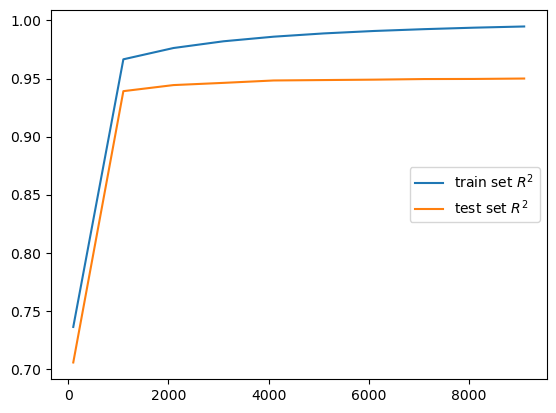

In [105]:
gbmr = GradientBoostingRegressor()

start_time = time.time()

# Separate features and target variable
X = df_numerical.drop('SalePrice', axis=1)
y = df_numerical['SalePrice']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
n_estimators = 10100
gbmr.set_params(n_estimators=n_estimators, max_depth=3, learning_rate=0.01, 
                min_samples_leaf=1, subsample=0.2, min_samples_split=5, random_state=42)
train_r2n = []
test_r2n  = []
steps = range(100,10100,1000)

gbmr.fit(X_train, y_train)
gen_train = gbmr.staged_predict(X_train)
gen_test  = gbmr.staged_predict(X_test)

for n in range(n_estimators):
           predicted_train = next(gen_train)
           predicted_test  = next(gen_test)
           if n not in steps: continue
           train_r2n.append(r2_score(y_train, predicted_train))
           test_r2n.append(r2_score(y_test, predicted_test))   

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.2f} seconds")
plt.plot(steps, train_r2n, label='train set $R^2$')
plt.plot(steps, test_r2n, label='test set $R^2$')
plt.legend(loc=7)

In [110]:
start_time = time.time()

X = df_numerical.drop('SalePrice', axis=1)
y = df_numerical['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
steps = range(100, 10100, 1000)

gbmr = GradientBoostingRegressor(n_estimators=10100, max_depth=4, learning_rate=0.1, 
                min_samples_leaf=1, subsample=0.5, random_state=42)
gbmr.fit(X_train, y_train)
gen = gbmr.staged_predict(X_test)
r2_values_1n = []
for n, predicted_targets in enumerate(gen):
    if n not in steps:
        continue
    r2 = r2_score(y_test, predicted_targets)
    r2_values_1n.append(r2)
    
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.2f} seconds")


Elapsed Time: 39.02 seconds


In [112]:
r2_values_1n

[0.733475023373918,
 0.9430956976965249,
 0.9462941688559887,
 0.947584570587194,
 0.9489018257730091,
 0.9492676877421751,
 0.9493208748570688,
 0.949315949439388,
 0.9492960987139188,
 0.9493601450284559]

In [113]:
start_time = time.time()

# Separate features and target variable
X = df_numerical.drop('SalePrice', axis=1)
y = df_numerical['SalePrice']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'learning_rate': [0.008, 0.01, 0.012],
    'subsample': [0.2, 0.3, 0.4],
    'n_estimators': [5000, 6000, 7000],
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [3, 5, 7],
    # 'min_samples_leaf': [1, 2]
}

# Initialize the Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, scoring='r2', cv=5)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and their corresponding R2 score
print("Best Parameters:", grid_search.best_params_)
print("Best R-squared:", grid_search.best_score_)

# Get the best model
best_gb_model = grid_search.best_estimator_

# Make predictions on the test data using the best model
y_pred = best_gb_model.predict(X_test)

# Evaluate the model using R2
r2 = r2_score(y_test, y_pred)
print(f'R-squared on Test Data: {r2:.4f}')

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.2f} seconds")


Best Parameters: {'learning_rate': 0.008, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 6000, 'subsample': 0.3}
Best R-squared: 0.941400438914043
R-squared on Test Data: 0.9495
Elapsed Time: 34569.19 seconds


In [139]:
start_time = time.time()

results_list = []

gbmr = GradientBoostingRegressor()
gbmr.set_params(learning_rate=0.008, max_depth=3, min_samples_split=5, n_estimators=6000, subsample=0.3, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

X = df_numerical.drop('SalePrice', axis=1)
y = df_numerical['SalePrice']
r2_scores = cross_val_score(gbmr, X, y, scoring='r2', cv=kf)
results_list.append({
    'DataFrame': 'df_numerical',
    'Hyperparameters': 'best for numerical',
    'Fold 1 R2': r2_scores[0],
    'Fold 2 R2': r2_scores[1], 
    'Fold 3 R2': r2_scores[2], 
    'Fold 4 R2': r2_scores[3], 
    'Fold 5 R2': r2_scores[4], 
    'MLR Mean R2': r2_scores.mean(),
    'Standard Deviation': r2_scores.std()
})
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.2f} seconds")


X = df_with_dummies.drop('SalePrice', axis=1)
y = df_with_dummies['SalePrice']
r2_scores = cross_val_score(gbmr, X, y, scoring='r2', cv=kf)
results_list.append({
    'DataFrame': 'df_with_dummies',
    'Hyperparameters': 'best for numerical',
    'Fold 1 R2': r2_scores[0],
    'Fold 2 R2': r2_scores[1], 
    'Fold 3 R2': r2_scores[2], 
    'Fold 4 R2': r2_scores[3], 
    'Fold 5 R2': r2_scores[4], 
    'MLR Mean R2': r2_scores.mean(),
    'Standard Deviation': r2_scores.std()
})
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.2f} seconds")

gbmr.set_params(learning_rate=0.05, max_depth=4, min_samples_split=2, n_estimators=4000, subsample=0.5, random_state=42)

X = df_numerical.drop('SalePrice', axis=1)
y = df_numerical['SalePrice']
r2_scores = cross_val_score(gbmr, X, y, scoring='r2', cv=kf)
results_list.append({
    'DataFrame': 'df_numerical',
    'Hyperparameters': 'best for dummies',
    'Fold 1 R2': r2_scores[0],
    'Fold 2 R2': r2_scores[1], 
    'Fold 3 R2': r2_scores[2], 
    'Fold 4 R2': r2_scores[3], 
    'Fold 5 R2': r2_scores[4], 
    'MLR Mean R2': r2_scores.mean(),
    'Standard Deviation': r2_scores.std()
})
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.2f} seconds")


X = df_with_dummies.drop('SalePrice', axis=1)
y = df_with_dummies['SalePrice']
r2_scores = cross_val_score(gbmr, X, y, scoring='r2', cv=kf)
results_list.append({
    'DataFrame': 'df_with_dummies',
    'Hyperparameters': 'best for dummies',
    'Fold 1 R2': r2_scores[0],
    'Fold 2 R2': r2_scores[1], 
    'Fold 3 R2': r2_scores[2], 
    'Fold 4 R2': r2_scores[3], 
    'Fold 5 R2': r2_scores[4], 
    'MLR Mean R2': r2_scores.mean(),
    'Standard Deviation': r2_scores.std()
})
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.2f} seconds")


KF_results_df = pd.DataFrame(results_list)

Elapsed Time: 89.08 seconds
Elapsed Time: 192.20 seconds
Elapsed Time: 316.12 seconds
Elapsed Time: 463.34 seconds


In [140]:
KF_results_df

,DataFrame,Hyperparameters,Fold 1 R2,Fold 2 R2,Fold 3 R2,Fold 4 R2,Fold 5 R2,MLR Mean R2,Standard Deviation
0,df_numerical,best for numerical,0.946463,0.939116,0.954445,0.948746,0.932453,0.944244,0.007676
1,df_with_dummies,best for numerical,0.947867,0.941444,0.955837,0.946818,0.929374,0.944268,0.008753
2,df_numerical,best for dummies,0.942830,0.934574,0.943168,0.944214,0.929788,0.938915,0.005721
3,df_with_dummies,best for dummies,0.943867,0.936253,0.949264,0.940596,0.923500,0.938696,0.008705


In [142]:
# 'alpha': 0.5, 'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 1,
# 'min_samples_split': 10, 'min_weight_fraction_leaf': 0, 'n_estimators': 600, 'subsample': 0.7

start_time = time.time()

# results_list2 = []

gbmr = GradientBoostingRegressor()
gbmr.set_params(alpha=0.5, learning_rate=0.05, max_depth=3, min_samples_split=10, n_estimators=600, subsample=0.7, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

X = df_numerical.drop('SalePrice', axis=1)
y = df_numerical['SalePrice']
r2_scores = cross_val_score(gbmr, X, y, scoring='r2', cv=kf)
results_list.append({
    'DataFrame': 'df_numerical',
    'Hyperparameters': 'Charlotte',
    'Fold 1 R2': r2_scores[0],
    'Fold 2 R2': r2_scores[1], 
    'Fold 3 R2': r2_scores[2], 
    'Fold 4 R2': r2_scores[3], 
    'Fold 5 R2': r2_scores[4], 
    'MLR Mean R2': r2_scores.mean(),
    'Standard Deviation': r2_scores.std()
})
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.2f} seconds")

X = df_with_dummies.drop('SalePrice', axis=1)
y = df_with_dummies['SalePrice']
r2_scores = cross_val_score(gbmr, X, y, scoring='r2', cv=kf)
results_list.append({
    'DataFrame': 'df_with_dummies',
    'Hyperparameters': 'Charlotte',
    'Fold 1 R2': r2_scores[0],
    'Fold 2 R2': r2_scores[1], 
    'Fold 3 R2': r2_scores[2], 
    'Fold 4 R2': r2_scores[3], 
    'Fold 5 R2': r2_scores[4], 
    'MLR Mean R2': r2_scores.mean(),
    'Standard Deviation': r2_scores.std()
})
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.2f} seconds")

KF_results_df2 = pd.DataFrame(results_list)
KF_results_df2

Elapsed Time: 19.12 seconds
Elapsed Time: 41.54 seconds


,DataFrame,Hyperparameters,Fold 1 R2,Fold 2 R2,Fold 3 R2,Fold 4 R2,Fold 5 R2,MLR Mean R2,Standard Deviation
0,df_numerical,best for numerical,0.946463,0.939116,0.954445,0.948746,0.932453,0.944244,0.007676
1,df_with_dummies,best for numerical,0.947867,0.941444,0.955837,0.946818,0.929374,0.944268,0.008753
2,df_numerical,best for dummies,0.942830,0.934574,0.943168,0.944214,0.929788,0.938915,0.005721
3,df_with_dummies,best for dummies,0.943867,0.936253,0.949264,0.940596,0.923500,0.938696,0.008705
4,df_numerical,Charlotte,0.941053,0.934483,0.950131,0.940222,0.926376,0.938453,0.007847
5,df_with_dummies,Charlotte,0.943980,0.934012,0.951796,0.938310,0.924390,0.938497,0.009231


In [145]:
start_time = time.time()

results_list2 = []

gbmr = GradientBoostingRegressor()
gbmr.set_params(learning_rate=0.008, max_depth=3, min_samples_split=5, n_estimators=6000, subsample=0.3, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

X = df_numerical.drop('SalePrice', axis=1)
y = df_numerical['SalePrice']
r2_scores = cross_val_score(gbmr, X, y, scoring='r2', cv=kf)
results_list2.append({
    'DataFrame': 'df_numerical_withoutliers',
    'Hyperparameters': 'best for numerical',
    'Fold 1 R2': r2_scores[0],
    'Fold 2 R2': r2_scores[1], 
    'Fold 3 R2': r2_scores[2], 
    'Fold 4 R2': r2_scores[3], 
    'Fold 5 R2': r2_scores[4], 
    'MLR Mean R2': r2_scores.mean(),
    'Standard Deviation': r2_scores.std()
})
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.2f} seconds")


X = df_with_dummies.drop('SalePrice', axis=1)
y = df_with_dummies['SalePrice']
r2_scores = cross_val_score(gbmr, X, y, scoring='r2', cv=kf)
results_list2.append({
    'DataFrame': 'df_with_dummies_withoutliers',
    'Hyperparameters': 'best for numerical',
    'Fold 1 R2': r2_scores[0],
    'Fold 2 R2': r2_scores[1], 
    'Fold 3 R2': r2_scores[2], 
    'Fold 4 R2': r2_scores[3], 
    'Fold 5 R2': r2_scores[4], 
    'MLR Mean R2': r2_scores.mean(),
    'Standard Deviation': r2_scores.std()
})
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.2f} seconds")

gbmr.set_params(learning_rate=0.05, max_depth=4, min_samples_split=2, n_estimators=4000, subsample=0.5, random_state=42)

X = df_numerical.drop('SalePrice', axis=1)
y = df_numerical['SalePrice']
r2_scores = cross_val_score(gbmr, X, y, scoring='r2', cv=kf)
results_list2.append({
    'DataFrame': 'df_numerical_withoutliers',
    'Hyperparameters': 'best for dummies',
    'Fold 1 R2': r2_scores[0],
    'Fold 2 R2': r2_scores[1], 
    'Fold 3 R2': r2_scores[2], 
    'Fold 4 R2': r2_scores[3], 
    'Fold 5 R2': r2_scores[4], 
    'MLR Mean R2': r2_scores.mean(),
    'Standard Deviation': r2_scores.std()
})
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.2f} seconds")


X = df_with_dummies.drop('SalePrice', axis=1)
y = df_with_dummies['SalePrice']
r2_scores = cross_val_score(gbmr, X, y, scoring='r2', cv=kf)
results_list2.append({
    'DataFrame': 'df_with_dummies_withoutliers',
    'Hyperparameters': 'best for dummies',
    'Fold 1 R2': r2_scores[0],
    'Fold 2 R2': r2_scores[1], 
    'Fold 3 R2': r2_scores[2], 
    'Fold 4 R2': r2_scores[3], 
    'Fold 5 R2': r2_scores[4], 
    'MLR Mean R2': r2_scores.mean(),
    'Standard Deviation': r2_scores.std()
})
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.2f} seconds")


gbmr.set_params(alpha=0.5, learning_rate=0.05, max_depth=3, min_samples_split=10, n_estimators=600, subsample=0.7, random_state=42)

X = df_numerical.drop('SalePrice', axis=1)
y = df_numerical['SalePrice']
r2_scores = cross_val_score(gbmr, X, y, scoring='r2', cv=kf)
results_list2.append({
    'DataFrame': 'df_numerical_withoutliers',
    'Hyperparameters': 'Charlotte',
    'Fold 1 R2': r2_scores[0],
    'Fold 2 R2': r2_scores[1], 
    'Fold 3 R2': r2_scores[2], 
    'Fold 4 R2': r2_scores[3], 
    'Fold 5 R2': r2_scores[4], 
    'MLR Mean R2': r2_scores.mean(),
    'Standard Deviation': r2_scores.std()
})
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.2f} seconds")


X = df_with_dummies.drop('SalePrice', axis=1)
y = df_with_dummies['SalePrice']
r2_scores = cross_val_score(gbmr, X, y, scoring='r2', cv=kf)
results_list2.append({
    'DataFrame': 'df_with_dummies_withoutliers',
    'Hyperparameters': 'Charlotte',
    'Fold 1 R2': r2_scores[0],
    'Fold 2 R2': r2_scores[1], 
    'Fold 3 R2': r2_scores[2], 
    'Fold 4 R2': r2_scores[3], 
    'Fold 5 R2': r2_scores[4], 
    'MLR Mean R2': r2_scores.mean(),
    'Standard Deviation': r2_scores.std()
})
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.2f} seconds")

KF_results_df3 = pd.DataFrame(results_list2)

Elapsed Time: 89.30 seconds
Elapsed Time: 192.52 seconds
Elapsed Time: 315.30 seconds
Elapsed Time: 458.50 seconds
Elapsed Time: 477.41 seconds
Elapsed Time: 499.93 seconds


In [147]:
KF_results_df3

,DataFrame,Hyperparameters,Fold 1 R2,Fold 2 R2,Fold 3 R2,Fold 4 R2,Fold 5 R2,MLR Mean R2,Standard Deviation
0,df_numerical_withoutliers,best for numerical,0.946463,0.939116,0.954445,0.948746,0.932453,0.944244,0.007676
1,df_with_dummies_withoutliers,best for numerical,0.947867,0.941444,0.955837,0.946818,0.929374,0.944268,0.008753
2,df_numerical_withoutliers,best for dummies,0.942830,0.934574,0.943168,0.944214,0.929788,0.938915,0.005721
3,df_with_dummies_withoutliers,best for dummies,0.943867,0.936253,0.949264,0.940596,0.923500,0.938696,0.008705
4,df_numerical_withoutliers,Charlotte,0.941053,0.934483,0.950131,0.940222,0.926376,0.938453,0.007847
5,df_with_dummies_withoutliers,Charlotte,0.943980,0.934012,0.951796,0.938310,0.924390,0.938497,0.009231


In [151]:
gbmr

GradientBoostingRegressor(alpha=0.5, learning_rate=0.05, min_samples_split=10,
                          n_estimators=600, random_state=42, subsample=0.7)

In [149]:
KF_results_df2

,DataFrame,Hyperparameters,Fold 1 R2,Fold 2 R2,Fold 3 R2,Fold 4 R2,Fold 5 R2,MLR Mean R2,Standard Deviation
0,df_numerical,best for numerical,0.946463,0.939116,0.954445,0.948746,0.932453,0.944244,0.007676
1,df_with_dummies,best for numerical,0.947867,0.941444,0.955837,0.946818,0.929374,0.944268,0.008753
2,df_numerical,best for dummies,0.942830,0.934574,0.943168,0.944214,0.929788,0.938915,0.005721
3,df_with_dummies,best for dummies,0.943867,0.936253,0.949264,0.940596,0.923500,0.938696,0.008705
4,df_numerical,Charlotte,0.941053,0.934483,0.950131,0.940222,0.926376,0.938453,0.007847
5,df_with_dummies,Charlotte,0.943980,0.934012,0.951796,0.938310,0.924390,0.938497,0.009231


In [155]:
start_time = time.time()

gbmr = GradientBoostingRegressor()
kf = KFold(n_splits=5, shuffle=True, random_state=42)

X = df_with_dummies.drop('SalePrice', axis=1)
y = df_with_dummies['SalePrice']
r2_scores = cross_val_score(gbmr, X, y, scoring='r2', cv=kf)
results_list2.append({
    'DataFrame': 'df_with_dummies_withoutliers',
    'Hyperparameters': 'none',
    'Fold 1 R2': r2_scores[0],
    'Fold 2 R2': r2_scores[1], 
    'Fold 3 R2': r2_scores[2], 
    'Fold 4 R2': r2_scores[3], 
    'Fold 5 R2': r2_scores[4], 
    'MLR Mean R2': r2_scores.mean(),
    'Standard Deviation': r2_scores.std()
})
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.2f} seconds")

KF_results_df4 = pd.DataFrame(results_list2)
KF_results_df4

Elapsed Time: 5.29 seconds


,DataFrame,Hyperparameters,Fold 1 R2,Fold 2 R2,Fold 3 R2,Fold 4 R2,Fold 5 R2,MLR Mean R2,Standard Deviation
0,df_numerical_withoutliers,best for numerical,0.946463,0.939116,0.954445,0.948746,0.932453,0.944244,0.007676
1,df_with_dummies_withoutliers,best for numerical,0.947867,0.941444,0.955837,0.946818,0.929374,0.944268,0.008753
2,df_numerical_withoutliers,best for dummies,0.942830,0.934574,0.943168,0.944214,0.929788,0.938915,0.005721
3,df_with_dummies_withoutliers,best for dummies,0.943867,0.936253,0.949264,0.940596,0.923500,0.938696,0.008705
4,df_numerical_withoutliers,Charlotte,0.941053,0.934483,0.950131,0.940222,0.926376,0.938453,0.007847
5,df_with_dummies_withoutliers,Charlotte,0.943980,0.934012,0.951796,0.938310,0.924390,0.938497,0.009231
6,df_numerical_withoutliers,none,0.932905,0.923318,0.941301,0.935080,0.915313,0.929583,0.009181
7,df_with_dummies_withoutliers,none,0.929993,0.926088,0.939313,0.931633,0.913060,0.928017,0.008626


In [167]:
df_with_dummies.to_csv('NH_DF.csv', index=False)

In [168]:
CW_DF = pd.read_csv('CharlotteX.csv')
CW_DFy = pd.read_csv('y.csv')


In [171]:
start_time = time.time()

gbmr = GradientBoostingRegressor()
gbmr.set_params(learning_rate=0.008, max_depth=3, min_samples_split=5, n_estimators=6000, subsample=0.3, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

X = CW_DF
y = CW_DFy
r2_scores = cross_val_score(gbmr, X, y, scoring='r2', cv=kf)
results_list2.append({
    'DataFrame': 'charlottedf',
    'Hyperparameters': 'nhbestdnnum',
    'Fold 1 R2': r2_scores[0],
    'Fold 2 R2': r2_scores[1], 
    'Fold 3 R2': r2_scores[2], 
    'Fold 4 R2': r2_scores[3], 
    'Fold 5 R2': r2_scores[4], 
    'MLR Mean R2': r2_scores.mean(),
    'Standard Deviation': r2_scores.std()
})
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.2f} seconds")

KF_results_df4 = pd.DataFrame(results_list2)
KF_results_df4

Elapsed Time: 99.54 seconds


,DataFrame,Hyperparameters,Fold 1 R2,Fold 2 R2,Fold 3 R2,Fold 4 R2,Fold 5 R2,MLR Mean R2,Standard Deviation
0,df_numerical_withoutliers,best for numerical,0.946463,0.939116,0.954445,0.948746,0.932453,0.944244,0.007676
1,df_with_dummies_withoutliers,best for numerical,0.947867,0.941444,0.955837,0.946818,0.929374,0.944268,0.008753
2,df_numerical_withoutliers,best for dummies,0.942830,0.934574,0.943168,0.944214,0.929788,0.938915,0.005721
3,df_with_dummies_withoutliers,best for dummies,0.943867,0.936253,0.949264,0.940596,0.923500,0.938696,0.008705
4,df_numerical_withoutliers,Charlotte,0.941053,0.934483,0.950131,0.940222,0.926376,0.938453,0.007847
5,df_with_dummies_withoutliers,Charlotte,0.943980,0.934012,0.951796,0.938310,0.924390,0.938497,0.009231
6,df_numerical_withoutliers,none,0.932905,0.923318,0.941301,0.935080,0.915313,0.929583,0.009181
7,df_with_dummies_withoutliers,none,0.929993,0.926088,0.939313,0.931633,0.913060,0.928017,0.008626
8,charlottedf,none,0.928611,0.853361,0.909741,0.930059,0.909130,0.906180,0.027873
9,charlottedf,nhbestdnnum,0.941829,0.860590,0.918833,0.949959,0.925525,0.919347,0.031411


In [177]:
feature_importances = gbmr.feature_importances_
# Create a DataFrame to display feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df.head(25))

           Feature  Importance
36         TotalSF    0.372304
3      OverallQual    0.269457
35             Age    0.031817
7       BsmtFinSF1    0.024152
0        GrLivArea    0.018969
45   KitchenQual_n    0.018475
2          LotArea    0.017600
19      GarageArea    0.016183
5     YearRemodAdd    0.013575
38      BsmtQual_n    0.013378
6       MasVnrArea    0.011461
18      GarageCars    0.010954
4      OverallCond    0.009118
9        BsmtUnfSF    0.008959
40     ExterQual_n    0.007961
41   FireplaceQu_n    0.007870
11        1stFlrSF    0.007042
10     TotalBsmtSF    0.006753
1      LotFrontage    0.006567
16      Fireplaces    0.005017
12        2ndFlrSF    0.004995
30       longitude    0.004989
29        latitude    0.004794
250   SaleType_Oth    0.004590
17     GarageYrBlt    0.004563


In [176]:
gbmr.fit(X,y)
gbmr.feature_importances_

array([1.89692880e-02, 6.56682923e-03, 1.76000766e-02, 2.69457383e-01,
       9.11826481e-03, 1.35751424e-02, 1.14607029e-02, 2.41517938e-02,
       1.21538466e-03, 8.95865959e-03, 6.75300579e-03, 7.04175751e-03,
       4.99466524e-03, 2.01708338e-04, 1.08096949e-03, 1.41486903e-03,
       5.01664182e-03, 4.56314663e-03, 1.09543183e-02, 1.61828748e-02,
       3.36328825e-03, 2.88885680e-03, 1.57497709e-03, 2.75427153e-04,
       3.26639411e-03, 9.85979489e-05, 1.40544086e-04, 2.13025805e-03,
       9.19252677e-04, 4.79444591e-03, 4.98900443e-03, 4.00300123e-03,
       2.49562635e-03, 3.00009888e-03, 3.09377770e-03, 3.18174306e-02,
       3.72303702e-01, 3.34347108e-04, 1.33783199e-02, 4.31428561e-04,
       7.96107809e-03, 7.86957148e-03, 1.78081480e-03, 1.64354302e-04,
       1.43753785e-03, 1.84751236e-02, 4.48845478e-03, 3.86161359e-03,
       2.43976413e-04, 2.33414300e-03, 4.12031556e-03, 6.27171300e-04,
       6.76530814e-04, 1.94916288e-04, 2.56556311e-05, 6.05084839e-05,
      

In [175]:
X = df_with_dummies.drop('SalePrice', axis=1)
y = df_with_dummies['SalePrice']

# progress bar trial

In [90]:
# import time
from tqdm import tqdm
from itertools import product
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.metrics import r2_score
# import pandas as pd

# Assume df_with_dummies is your DataFrame with features and target variable

start_time = time.time()

# Separate features and target variable
X = df_with_dummies.drop('SalePrice', axis=1)
y = df_with_dummies['SalePrice']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    # 'learning_rate': [0.1, 0.05, 0.01, 0.001],
    # 'subsample': [1.0, 0.8, 0.7, 0.6, 0.5],
    # 'n_estimators': [100, 200, 300],  # Add more values based on your computational resources
    # 'max_depth': [3, 4, 5],  # Adjust based on your dataset characteristics
    # 'min_samples_split': [2, 5, 10],
    # 'min_samples_leaf': [1, 2, 4]
    'min_samples_leaf': [1, 2],
    'learning_rate': [0.1, 0.01],
}

# Initialize the Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, scoring='r2', cv=5)

# Perform the grid search with tqdm progress bar
param_combinations = list(product(*param_grid.values()))
for _ in tqdm(range(len(param_combinations)), desc="Grid Search Progress"):
    grid_search.fit(X_train, y_train)

# Print the best parameters and their corresponding R2 score
print("Best Parameters:", grid_search.best_params_)
print("Best R-squared:", grid_search.best_score_)

# Get the best model
best_gb_model = grid_search.best_estimator_

# Make predictions on the test data using the best model
y_pred = best_gb_model.predict(X_test)

# Evaluate the model using R2
r2 = r2_score(y_test, y_pred)
print(f'R-squared on Test Data: {r2:.4f}')

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.2f} seconds")


Grid Search Progress: 100%|███████████████████████| 4/4 [01:09<00:00, 17.42s/it]

Best Parameters: {'learning_rate': 0.1, 'min_samples_leaf': 2}
Best R-squared: 0.9261639129704987
R-squared on Test Data: 0.9310
Elapsed Time: 69.69 seconds
